# **HW5: Autoencoders**

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version of it. Next, we will experiment with the application of a denoising autoencoder. Finally, we will experiment with sequential domains, considering the IMDB dataset, alredy used in HW4.

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
Each value is between 0 and 255, and represents a pixel in an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, we will split the test set, in the test and validation set.

In [0]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

##Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW we will focus our attention on SVD decomposition. Indeed it is more numerical stable. Given a matrix X, the SVD decomposes a matrix into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T$$

SVD is implemented in NumPy as np.linalg.svd. In our case the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that the X matrix, in our case, will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore, to optimize the memory consumption we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we can relate the decomposition of the covariance matrix $C= X^T \cdot X$ to the decomposition of $X$. In fact

$$ C= X^T \cdot X = U \cdot S \cdot V^T \cdot V\cdot S \cdot U^T  = U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the Colab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [0]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data, and compute the compressed version of the training set and the test set.

**To complete: What happens varying the ENCODING_DIM? test  and discuss the results in this cell**

I used these values of ENCODING_DIM:


*   180: training mse: 0.00267 - test mse: 0.00265. Whit this size of the compressed verson of input data the model is better then the model using ENCODING_DIM = 120, but there weren't differences when I whatched the reconstructions of the inputs.
*   240: training mse: 0.00161 - test mse: 0.00159. Whit this size of the compressed version of input data the model is better then the models using ENCODING_DIM = 180 and ENCODING_DIM = 120. The reconstructions of the inputs are very accurate.
* 60: training mse: 0.00994 - test mse: 0.00967. Whit this ENCODING_DIM the reconstructions of the inputs aren't very clear but in any case you can distinguish the numbers.
* 20: training mse: 0.02405 - test mse: 0.02356. In this case the recontructions of the inputs aren't clear and you can't didtinguish the numbers.





In [0]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)



Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images

In [0]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)

In [112]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [0]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed, by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images shows input data, while the second one shows the reconstructions.

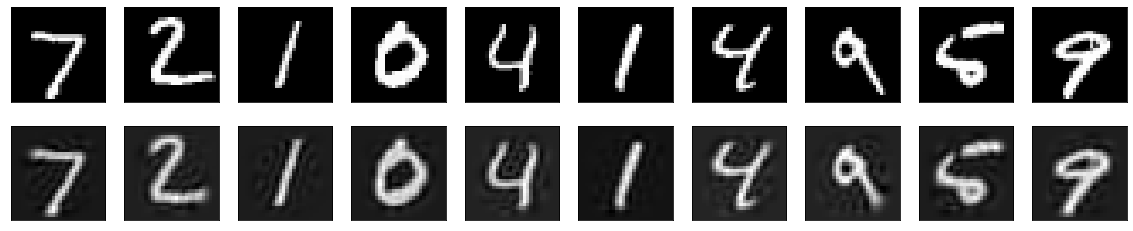

In [114]:
plot_img(10, x_test, x_test_reco)

## Exercise 5.1: Shallow Linear Autoencoder
Let's define the model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various parts of the model (encoder and decoder) separately and create the final model. 

**To complete: check the results and compare them with the results obtained by SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.**


In [0]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [116]:
autoencoder.summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_68 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_69 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [117]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0443 - val_loss: 0.0147
Epoch 2/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0125 - val_loss: 0.0093
Epoch 3/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 4/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 5/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 6/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 7/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 9/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 11/

Plot the loss and the accuracy curves, and the accuracy on the test set.

In [0]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00479


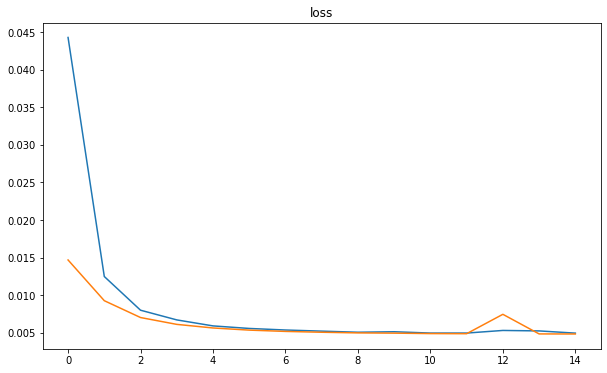

In [119]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

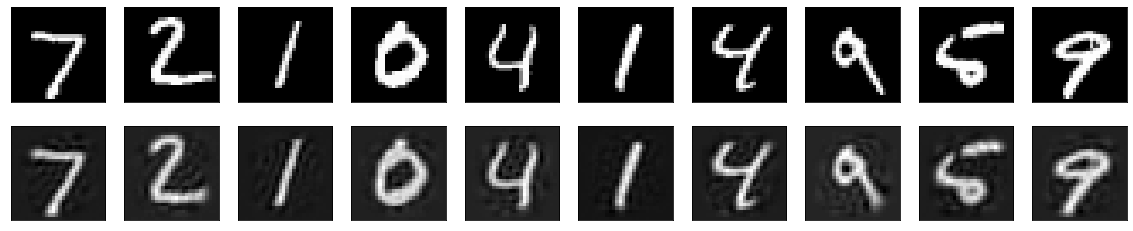

In [120]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


The SVD is a technique for calculating the PCA space in a numerically more stable way. The Shallow linear autoencoder learns to do the same thing. An SVD could be converging to autoencoder in which the activation function is a linear function. In fact the results of SVD are training mse: 0.00464 - test mse: 0.00455 and they are very similar to Shallow Linear Autoencoder results (validation loss: 0.0048 - test mse: 0.00476) so as you can see the model converges quite nicely and the validation loss has dropped to zero.

##Exercise  5.2: Shallow non-linear autoencoders

**To complete: replicate the code of exercise 5.1 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1.**

I choose the sigmoid function as non-linear activation because it work better than relu function and it is possible because all values of data are normalized between 0 and 1. With the relu function the model has loss: 0.0108 and test mse: 0.01080; with the sigmoid function the model has loss: 0.0044 test mse: 0.00443.

Using non-linear function the results are loss: 0.0044 - test mse: 0.00443. The results are very similar to the linear autoencoder and also in this case the model converges quite nicely and the validation loss has dropped to zero.




In [0]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


In [122]:
autoencoder.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_70 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_71 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


In [123]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0544 - val_loss: 0.0349
Epoch 2/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0282 - val_loss: 0.0224
Epoch 3/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0194 - val_loss: 0.0165
Epoch 4/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0148 - val_loss: 0.0130
Epoch 5/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0120 - val_loss: 0.0108
Epoch 6/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0101 - val_loss: 0.0093
Epoch 7/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 8/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 9/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 10/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 11/

313/313 - 0s - loss: 0.0043
test mse: 0.00428


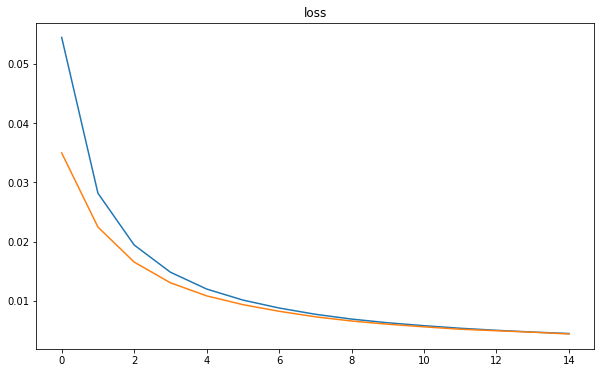

In [124]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

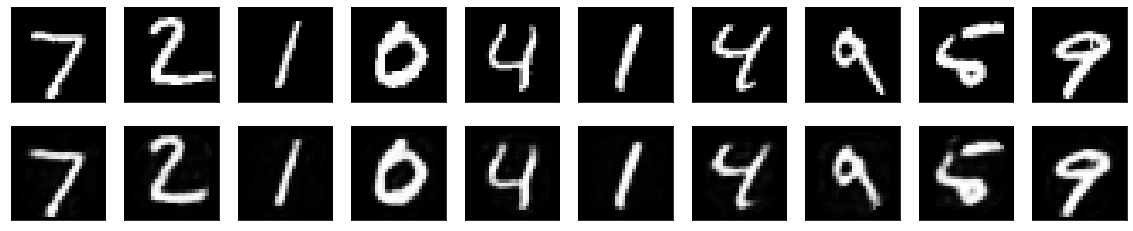

In [125]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


## Exercise 5.3: Deep Autoencoder
**To_complete: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (e.g., 748->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e, 128->748, the resulting structure recall an hourglass).
Similarly than what did above, print the model summary, the loss curve during the training, the achieved loss on the test set, and some input image with the correspondent decoding.**


In [0]:
input_img = tf.keras.layers.Input(shape=(784,))
# 
#To_complete
encoded = tf.keras.layers.Dense(units=584, activation='sigmoid')(input_img)
encoded = tf.keras.layers.Dense(units=392, activation='sigmoid')(encoded)
encoded = tf.keras.layers.Dense(units=98, activation='sigmoid')(encoded)
decoded = tf.keras.layers.Dense(units=392, activation='sigmoid')(encoded)
decoded = tf.keras.layers.Dense(units=584, activation='sigmoid')(decoded)

final_decoded = tf.keras.layers.Dense(units=784, activation='sigmoid')(decoded)
autoencoder = tf.keras.models.Model(input_img, final_decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [127]:
autoencoder.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_72 (Dense)             (None, 584)               458440    
_________________________________________________________________
dense_73 (Dense)             (None, 392)               229320    
_________________________________________________________________
dense_74 (Dense)             (None, 98)                38514     
_________________________________________________________________
dense_75 (Dense)             (None, 392)               38808     
_________________________________________________________________
dense_76 (Dense)             (None, 584)               229512    
_________________________________________________________________
dense_77 (Dense)             (None, 784)               458

In [128]:
history = autoencoder.fit(x_train, x_train, epochs=20, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/20
98/98 [==============================] - 9s 89ms/step - loss: 0.0707 - val_loss: 0.0675
Epoch 2/20
98/98 [==============================] - 9s 88ms/step - loss: 0.0675 - val_loss: 0.0675
Epoch 3/20
98/98 [==============================] - 9s 88ms/step - loss: 0.0674 - val_loss: 0.0661
Epoch 4/20
98/98 [==============================] - 9s 89ms/step - loss: 0.0603 - val_loss: 0.0569
Epoch 5/20
98/98 [==============================] - 9s 89ms/step - loss: 0.0534 - val_loss: 0.0485
Epoch 6/20
98/98 [==============================] - 9s 89ms/step - loss: 0.0451 - val_loss: 0.0413
Epoch 7/20
98/98 [==============================] - 9s 88ms/step - loss: 0.0388 - val_loss: 0.0352
Epoch 8/20
98/98 [==============================] - 9s 88ms/step - loss: 0.0335 - val_loss: 0.0309
Epoch 9/20
98/98 [==============================] - 9s 89ms/step - loss: 0.0294 - val_loss: 0.0270
Epoch 10/20
98/98 [==============================] - 9s 89ms/step - loss: 0.0262 - val_loss: 0.0243
Epoch 11/

313/313 - 1s - loss: 0.0095
test mse: 0.00947


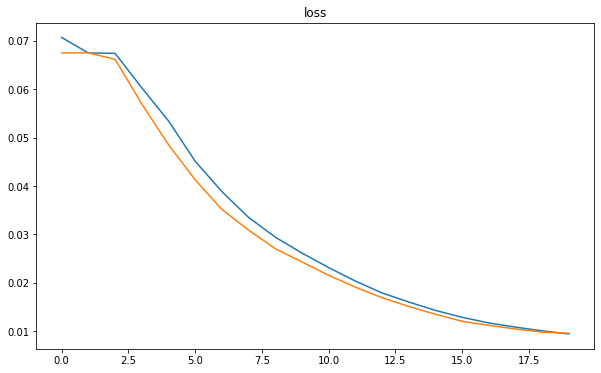

In [129]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

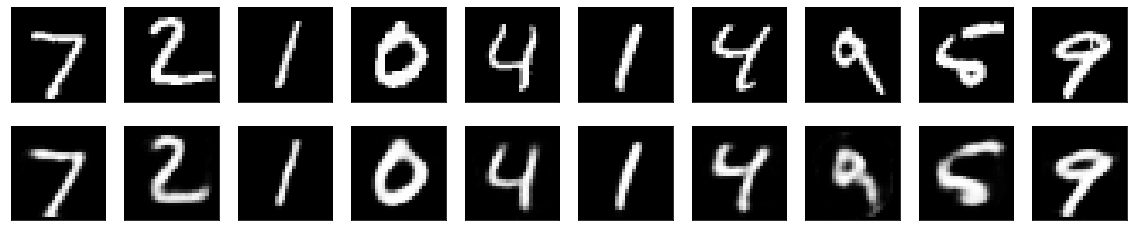

In [130]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## Exercise 5.4: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data, and to check how much it influences the denoising capability of the autoencoder.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

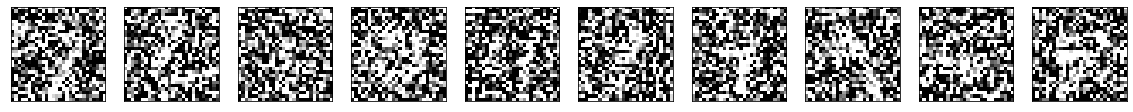

In [132]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**To_complete: use the same model defined in the exercise 5.3.**

In [0]:
input_img = tf.keras.layers.Input(shape=(784,))

#To_complete
encoded = tf.keras.layers.Dense(units=584, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(units=392, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(units=98, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(units=392, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(units=584, activation='relu')(decoded)

final_decoded = tf.keras.layers.Dense(units=784, activation='sigmoid')(decoded)
autoencoder = tf.keras.models.Model(input_img, final_decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [134]:
autoencoder.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_78 (Dense)             (None, 584)               458440    
_________________________________________________________________
dense_79 (Dense)             (None, 392)               229320    
_________________________________________________________________
dense_80 (Dense)             (None, 98)                38514     
_________________________________________________________________
dense_81 (Dense)             (None, 392)               38808     
_________________________________________________________________
dense_82 (Dense)             (None, 584)               229512    
_________________________________________________________________
dense_83 (Dense)             (None, 784)               458

**To complete: Train the model by passing the noisy input and the clean target.**

In [135]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/15
98/98 [==============================] - 9s 89ms/step - loss: 0.0707 - val_loss: 0.0625
Epoch 2/15
98/98 [==============================] - 9s 88ms/step - loss: 0.0618 - val_loss: 0.0605
Epoch 3/15
98/98 [==============================] - 9s 88ms/step - loss: 0.0583 - val_loss: 0.0569
Epoch 4/15
98/98 [==============================] - 9s 88ms/step - loss: 0.0562 - val_loss: 0.0551
Epoch 5/15
98/98 [==============================] - 9s 89ms/step - loss: 0.0549 - val_loss: 0.0540
Epoch 6/15
98/98 [==============================] - 9s 88ms/step - loss: 0.0538 - val_loss: 0.0535
Epoch 7/15
98/98 [==============================] - 9s 90ms/step - loss: 0.0531 - val_loss: 0.0530
Epoch 8/15
98/98 [==============================] - 12s 118ms/step - loss: 0.0525 - val_loss: 0.0524
Epoch 9/15
98/98 [==============================] - 9s 89ms/step - loss: 0.0520 - val_loss: 0.0521
Epoch 10/15
98/98 [==============================] - 9s 89ms/step - loss: 0.0516 - val_loss: 0.0515
Epoch 1

313/313 - 1s - loss: 0.0491
test mse: 0.04911


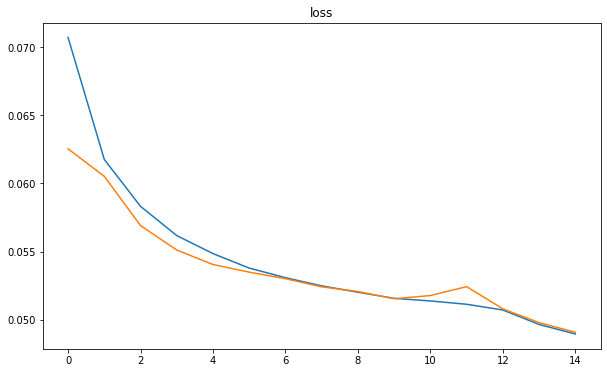

In [136]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

Check the result by plotting some input images and the correspondent denoised outputs

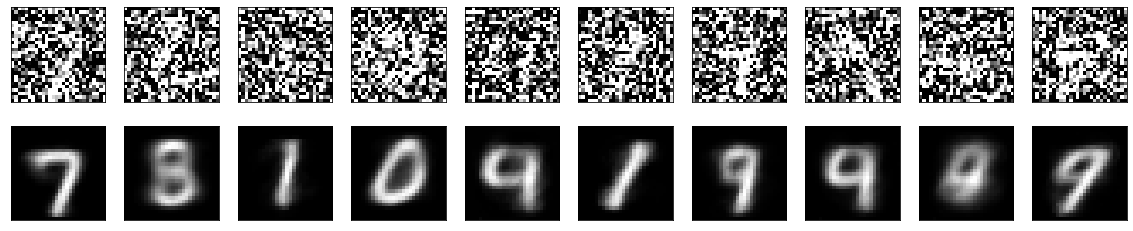

In [137]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

The autoencoder isn't very well in the case in which i used the same model defined in the exercise 5.3. So I changed the activation function from sigmoid to relu and the result is better.

## Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [0]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by the IMDB dataset loader, we use the to_categorical method to transform them in the correspondent one-hot representations.

In [0]:
from keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in exercise 5.1, while the encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense layer on each time step of the sequence. 

Since the output will be a one-hot representation, let's use the binary_crossentropy as loss and the CategoricalAccuracy as metric.

In [140]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 90, 50)            7550      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [141]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 75ms/step - loss: 0.1920 - categorical_accuracy: 0.1260 - val_loss: 0.0892 - val_categorical_accuracy: 0.3167
Epoch 2/50
79/79 [==============================] - 6s 74ms/step - loss: 0.0743 - categorical_accuracy: 0.4289 - val_loss: 0.0663 - val_categorical_accuracy: 0.4711
Epoch 3/50
79/79 [==============================] - 6s 74ms/step - loss: 0.0597 - categorical_accuracy: 0.4950 - val_loss: 0.0556 - val_categorical_accuracy: 0.5014
Epoch 4/50
79/79 [==============================] - 6s 74ms/step - loss: 0.0514 - categorical_accuracy: 0.5307 - val_loss: 0.0488 - val_categorical_accuracy: 0.5381
Epoch 5/50
79/79 [==============================] - 6s 75ms/step - loss: 0.0475 - categorical_accuracy: 0.5674 - val_loss: 0.0455 - val_categorical_accuracy: 0.6017
Epoch 6/50
79/79 [==============================] - 6s 74ms/step - loss: 0.0418 - categorical_accuracy: 0.6232 - val_loss: 0.0400 - val_categorical_accuracy: 0.6178
Epoch 7/50

Let's plot the accuracy and the loss curves and check the reconstruction capability of the model by plotting the reconstruction of a test sample.

40/40 - 0s - loss: 0.0096 - categorical_accuracy: 0.9462
categorical_accuracy: 94.62%


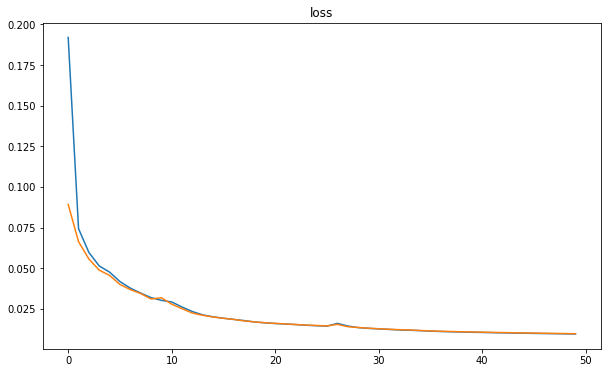

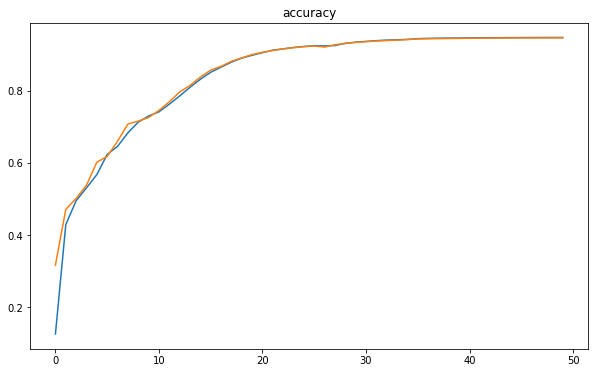

In [142]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [143]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that up <oov> in all of that time but that <oov> the <oov> is <oov> a and <oov> a in just about <oov> <oov> <oov> <oov> as some other <oov> but <oov> out it <oov> like <oov> <oov> of the only it <oov> <oov> there <oov> other <oov> <oov> <oov> for <oov> <oov> in the <oov> <oov> this is a really bad you that <oov> <oov> <oov> than a <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> on <oov>


##Exercise 5.5: Non-Linear Autoencoder for sequences

**To complete: Replicate the code of the exercise above, but instead of using a simpleRNN with linear activations do use non-linear activation functions and a LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.**

**Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.**

I use a sigmoid function for LSTM and a softmax function for the layer after LSTM because the model is better than other that use other activation function in fact the accuracy is 100% 
Using softmax function in the output layer is a better choise because we have a one-hot representation and softmax give in output an array of values ​​whose sum is 1 and it is reasonable to expect that the value closest to 1 in the output is consistent with the previous transformation into categorical.

In [144]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='sigmoid')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [145]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 10s 131ms/step - loss: 0.0428 - categorical_accuracy: 0.4149 - val_loss: 0.0371 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 10s 129ms/step - loss: 0.0362 - categorical_accuracy: 0.4710 - val_loss: 0.0361 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] - 10s 130ms/step - loss: 0.0348 - categorical_accuracy: 0.4710 - val_loss: 0.0340 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 10s 130ms/step - loss: 0.0319 - categorical_accuracy: 0.4710 - val_loss: 0.0304 - val_categorical_accuracy: 0.4614
Epoch 5/50
79/79 [==============================] - 10s 131ms/step - loss: 0.0279 - categorical_accuracy: 0.4711 - val_loss: 0.0261 - val_categorical_accuracy: 0.4620
Epoch 6/50
79/79 [==============================] - 10s 131ms/step - loss: 0.0234 - categorical_accuracy: 0.5941 - val_loss: 0.0214 - val_categorical_accuracy: 0.698

40/40 - 1s - loss: 3.4037e-05 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


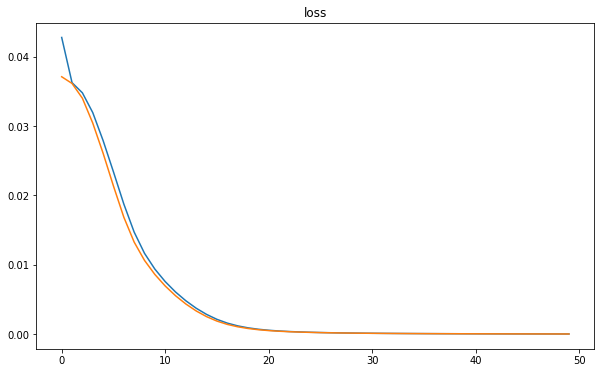

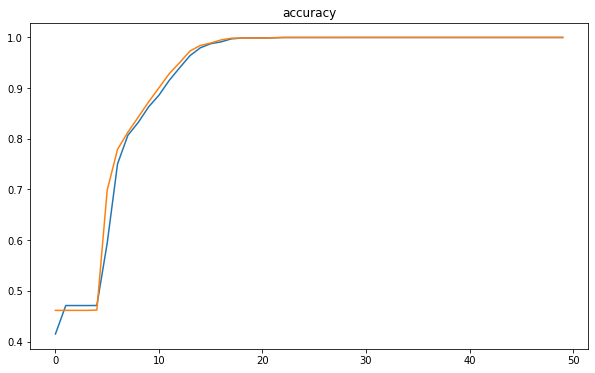

In [146]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [147]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
